In [16]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [17]:
def generate_session(t_max=10000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: break
            
    #print("Ticks: {}".format(t))
    return states, actions, total_reward
        

In [18]:
#generate_session()

In [19]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    mask = np.greater_equal( rewards_batch,  reward_threshold )
    #mask = np.greater( rewards_batch,  reward_threshold )
    
    elite_states  = sum( [ states_batch[i] for i in range(len(states_batch)) if mask[i]], [])
    elite_actions = sum( [ actions_batch[i] for i in range(len(actions_batch)) if mask[i]], [])
    
    return elite_states, elite_actions
    

In [20]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [21]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("MountainCar-v0").env
env.reset()
n_actions = env.action_space.n

#plt.imshow(env.render("rgb_array"))

In [22]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(32, 32),
                      activation='tanh',
                      warm_start=True,
                      max_iter=1,
                      learning_rate_init=0.001
                     )
agent.fit([env.reset()]*n_actions, list(range(n_actions)));

c:\program files\python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [23]:
#from joblib import Parallel, delayed

#def generate_several_sessions(n_sessions):
 #   with Parallel(n_jobs=n_sessions, backend='threading') as parallel:
 #       sessions = parallel(delayed(generate_session)() for i in range(n_sessions))
 #   return sessions

In [24]:
from sklearn.externals.joblib import Parallel, delayed

def generate_several_sessions(n_sessions):
    with Parallel(n_jobs=n_sessions, backend='threading') as parallel:
        sessions = parallel(delayed(generate_session)() for i in range(n_sessions))
    return sessions

mean reward = -99.560, threshold=-98.000


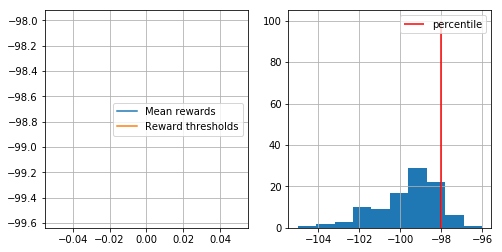

90


In [ ]:
n_sessions = 100
percentile = 90 # 90 - was ~ -149 ! Try 80, 85
log = []
n_past_iteration = 0 # 1 + 90: ~ -20

batch_states, batch_actions, batch_rewards = [],[],[]

for i in range(80):
    #sessions = [generate_session() for i in range(n_sessions)]    
    sessions = generate_several_sessions(n_sessions)

    batch_states_, batch_actions_, batch_rewards_ = map(list, zip(*sessions))
    
    batch_states = batch_states_ + batch_states
    batch_actions = batch_actions_ + batch_actions
    batch_rewards = batch_rewards_ + batch_rewards    
    batch_states = batch_states[: (n_past_iteration+1) * n_sessions]
    batch_actions = batch_actions[: (n_past_iteration+1) * n_sessions]
    batch_rewards = batch_rewards[: (n_past_iteration+1) * n_sessions]

    elite_states, elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(batch_rewards, log, percentile, reward_range=[np.min(batch_rewards), np.max(batch_rewards)])
    
    #if np.mean(batch_rewards[n_sessions : ]) > -100:
    #    print("You Win!")
    #    break
        
    #percentile *= 0.99
    print(percentile)

In [10]:
from sklearn.externals import joblib
with open("MountainCar-v0.pkl", mode='wb') as model_f:
    joblib.dump(agent, model_f)

In [11]:
from sklearn.externals import joblib
with open("MountainCar-v0.pkl", mode='rb') as model_f:
    agent = joblib.load(model_f)

In [12]:
def generate_session(t_max=10000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: break
    return states, actions, total_reward
        

In [14]:
n_sessions = 100
#sessions = [generate_session() for i in range(n_sessions)]   
sessions = generate_several_sessions(n_sessions)
batch_states, batch_actions, batch_rewards = map(list, zip(*sessions))    
print(np.mean(batch_rewards))

-64.54
